# Introduction

In this notebook, we analyse a sample of PBMCs. Here, we cover clustering and cell type annotation of the data.

## Load packages

In [1]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

import os 
#doublet detection
import scrublet as scr
#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
import scanorama as scan
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb

#R interface
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri


In [58]:
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
sc.logging.print_header()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anndata2ri          1.0.6
annoy               NA
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              1.0.9
certifi             2020.12.05
cffi                1.14.4
chardet             4.0.0
cloudpickle         1.6.0
constants           NA
cycler              0.10.0
cython_runtime      NA
dask                2020.12.0
dateutil            2.8.1
decorator           4.4.2
fbpca               NA
future_fstrings     NA
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
intervaltree        NA
ipykernel           5.4.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.2

Of note, this notebook was created as part of a workshop, so we use extra large legend texts in all seaborn plots, but switch to smaller legends here to avoid overlap of the plot and the legend. You can set the context as well to 'poster' or 'paper'.

In [3]:
sb.set_context(context='talk')


In [4]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
#.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(DropletUtils)


# Set project file paths

We set up the file paths to the respective directories.

In [5]:
file_path = '/root/host_home/Documents/ICB/Teaching/2103_scanpy_HMGU_presenter/' 
#this is my file path please adapt it to your directory

File path to the raw data. They are usually stored at a different location than the rest of the project.

In [6]:
file_path_raw = file_path + '3k_PBMC/'

The data directory contains all processed data and `anndata` files. 

In [7]:
data_dir = file_path + 'PBMC_docker/data/' 

The tables directory contains all tabular data output, e.g. in `.csv` or `.xls` file format. That applies to differential expression test results or overview tables such as the number of cells per cell type.

In [8]:
table_dir = file_path + 'PBMC_docker/tables/'

The default figure path is a POSIX path calles 'figures'. If you don't change the default figure directory, scanpy creates a subdirectory where this notebook is located.  

In [57]:
sc.settings.figdir = file_path + 'PBMC_docker/figures/'

**Comment:** When you repeat certain analyses, it might be helpful to set a date variable and add it to every figure and table (see `datetime` Python package).

In [10]:
import datetime

today = datetime.date.today().strftime('%y%m%d') #creates a YYMMDD string of today's date

# Read data

The normalised dataset, which consists of 3k PBMCs (Human) provided by 10X Genomics.

In [12]:
adata = sc.read(data_dir + 'data_processed.h5ad')

# Downstream analysis

## Clustering

Clustering is a central component of the scRNA-seq analysis pipeline. To understand the data, we must identify cell types and states present. The first step of doing so is clustering. Performing Modularity optimization by Louvain community detection on the k-nearest-neighbour graph of cells has become an established practice in scRNA-seq analysis. Thus, this is the method of choice in this tutorial as well.

Here, we perform clustering at two resolutions. Investigating several resolutions allows us to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructure.

Clustering is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph. (see `sc.pp.pca()` and `sc.pp.neighbors()` functions used in the visualization section).

Compute a `leiden` clustering with two different resolutions (`0.5` and `1`). Compare the clusterings in a table and visualize the clustering in an embedding.

In [17]:
# Perform clustering - using highly variable genes
sc.tl.leiden(adata, resolution=1.5, key_added='leiden_r1.5')
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_r0.5')

running Leiden clustering
    finished: found 20 clusters and added
    'leiden_r1.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)


In [18]:
pd.crosstab(adata.obs['leiden_r0.5'], adata.obs['leiden_r1.5'])

leiden_r1.5    0    1    2    3    4    5    6    7    8    9   10   11   12  \
leiden_r0.5                                                                    
0              0    0    0    0  248  233  222  192    0    0    0    0    0   
1              0    0  282  257    0    0    0    0    0    0    0    0    0   
2            363    0    0    0    0    0    0    0  142    0    0    0    0   
3              0    0    0    0    0    0    0    0    0  180    0  142  141   
4              0  334    0    0    0    0    0    0    0    0    0    0    0   
5              0    0    0    0    0    0    0    0   42    0    0    0    0   
6              0    0    0    0    0    0    0    0    0    0  173    0    0   
7              0    0    0    0    0    0    0    0    0    0    0    0    0   
8              0    0    0    0    0    0    0    0    0    0    0    0    0   
9              0    0    0    0    0    0    0    0    0    0    0    0    0   

leiden_r1.5   13   14   15   16   17  18  19  
leiden_r0.5                                   
0              0    0    1    0    0   0   0  
1              0    0    0    0    0   0   0  
2              0    9    0    0    0   0   0  
3              0    0    7    0    0   0   0  
4              0    0  112    0    0   0   4  
5            137  126    0    0    0   0   0  
6              0    0    0    0    0   0   0  
7              0    0    0  116    0   0   0  
8              0    0    0    0  113   0   0  
9              0    0    0    0    0  34   8

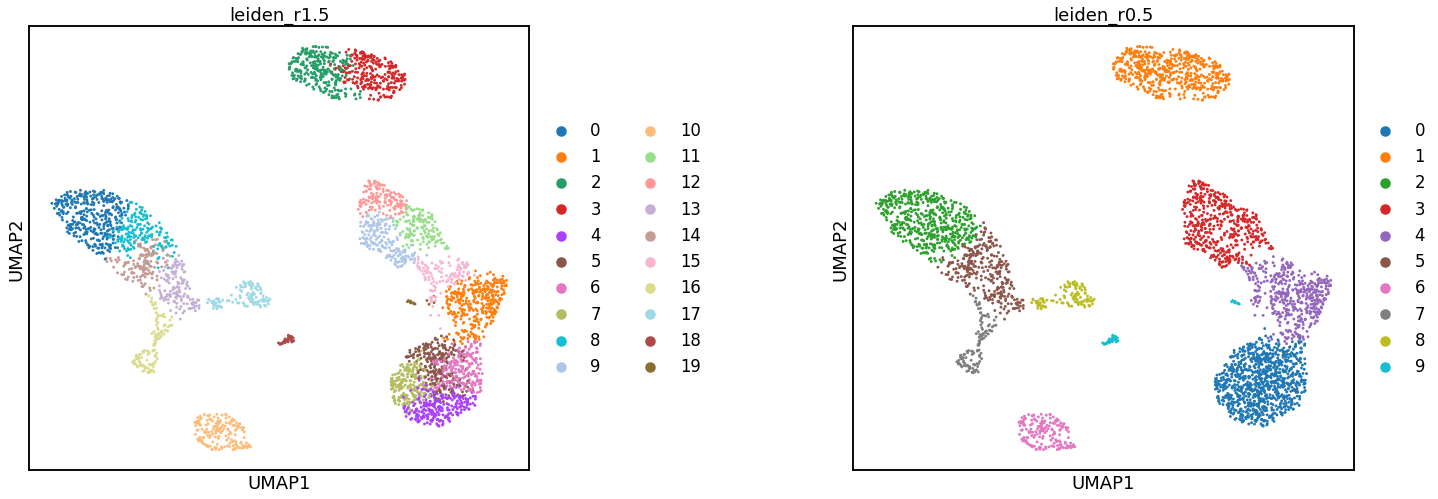

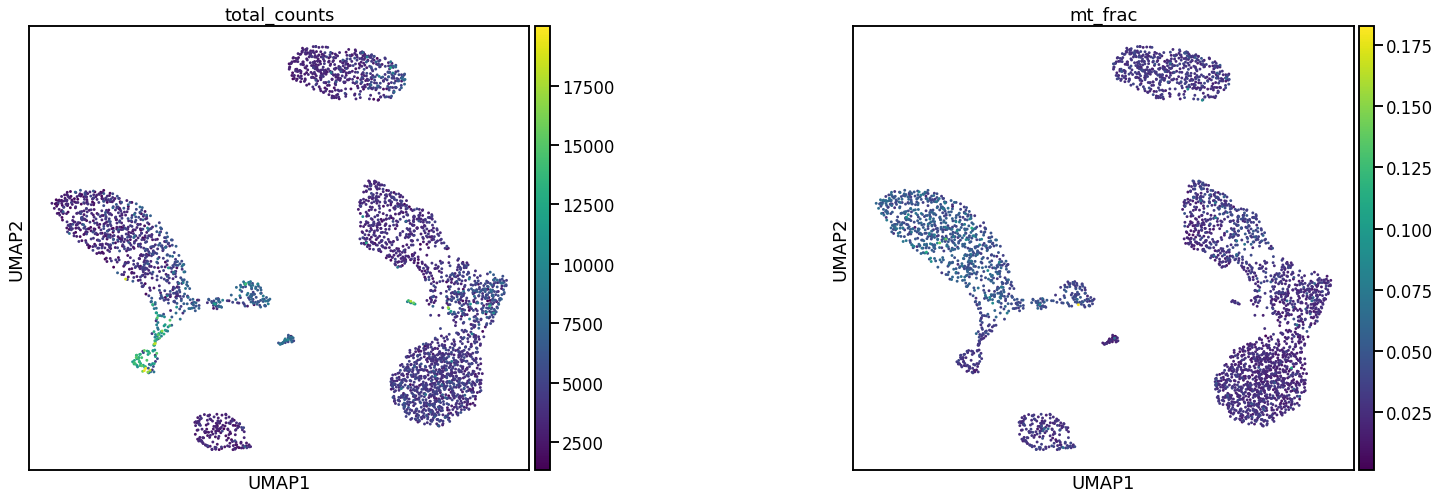

In [20]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['leiden_r1.5', 'leiden_r0.5'], wspace=0.5)
sc.pl.umap(adata, color=['total_counts', 'mt_frac'], wspace=0.5)

## Marker genes and cluster annotation 

To annotate the clusters we obtained, we find genes that are up-regulated in the cluster compared to all other clusters (marker genes). This differential expression test is performed by a *Welch t-test with overestimated variance* to be conservative. This is the default in `scanpy`. The test is automatically performed on the `.raw` data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.

As we are using the relevant mouse gut atlas from the literature in this case study, there is no other reference atlas which we use to annotate the cells by automated annotation. Thus, we do not use scmap or garnett here.

Compute the differential expression profile for each cluster with `rank_genes_groups` and visualize the results.

In [21]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden_r0.5', key_added='rank_genes_r0.5')

ranking genes
    finished: added to `.uns['rank_genes_r0.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


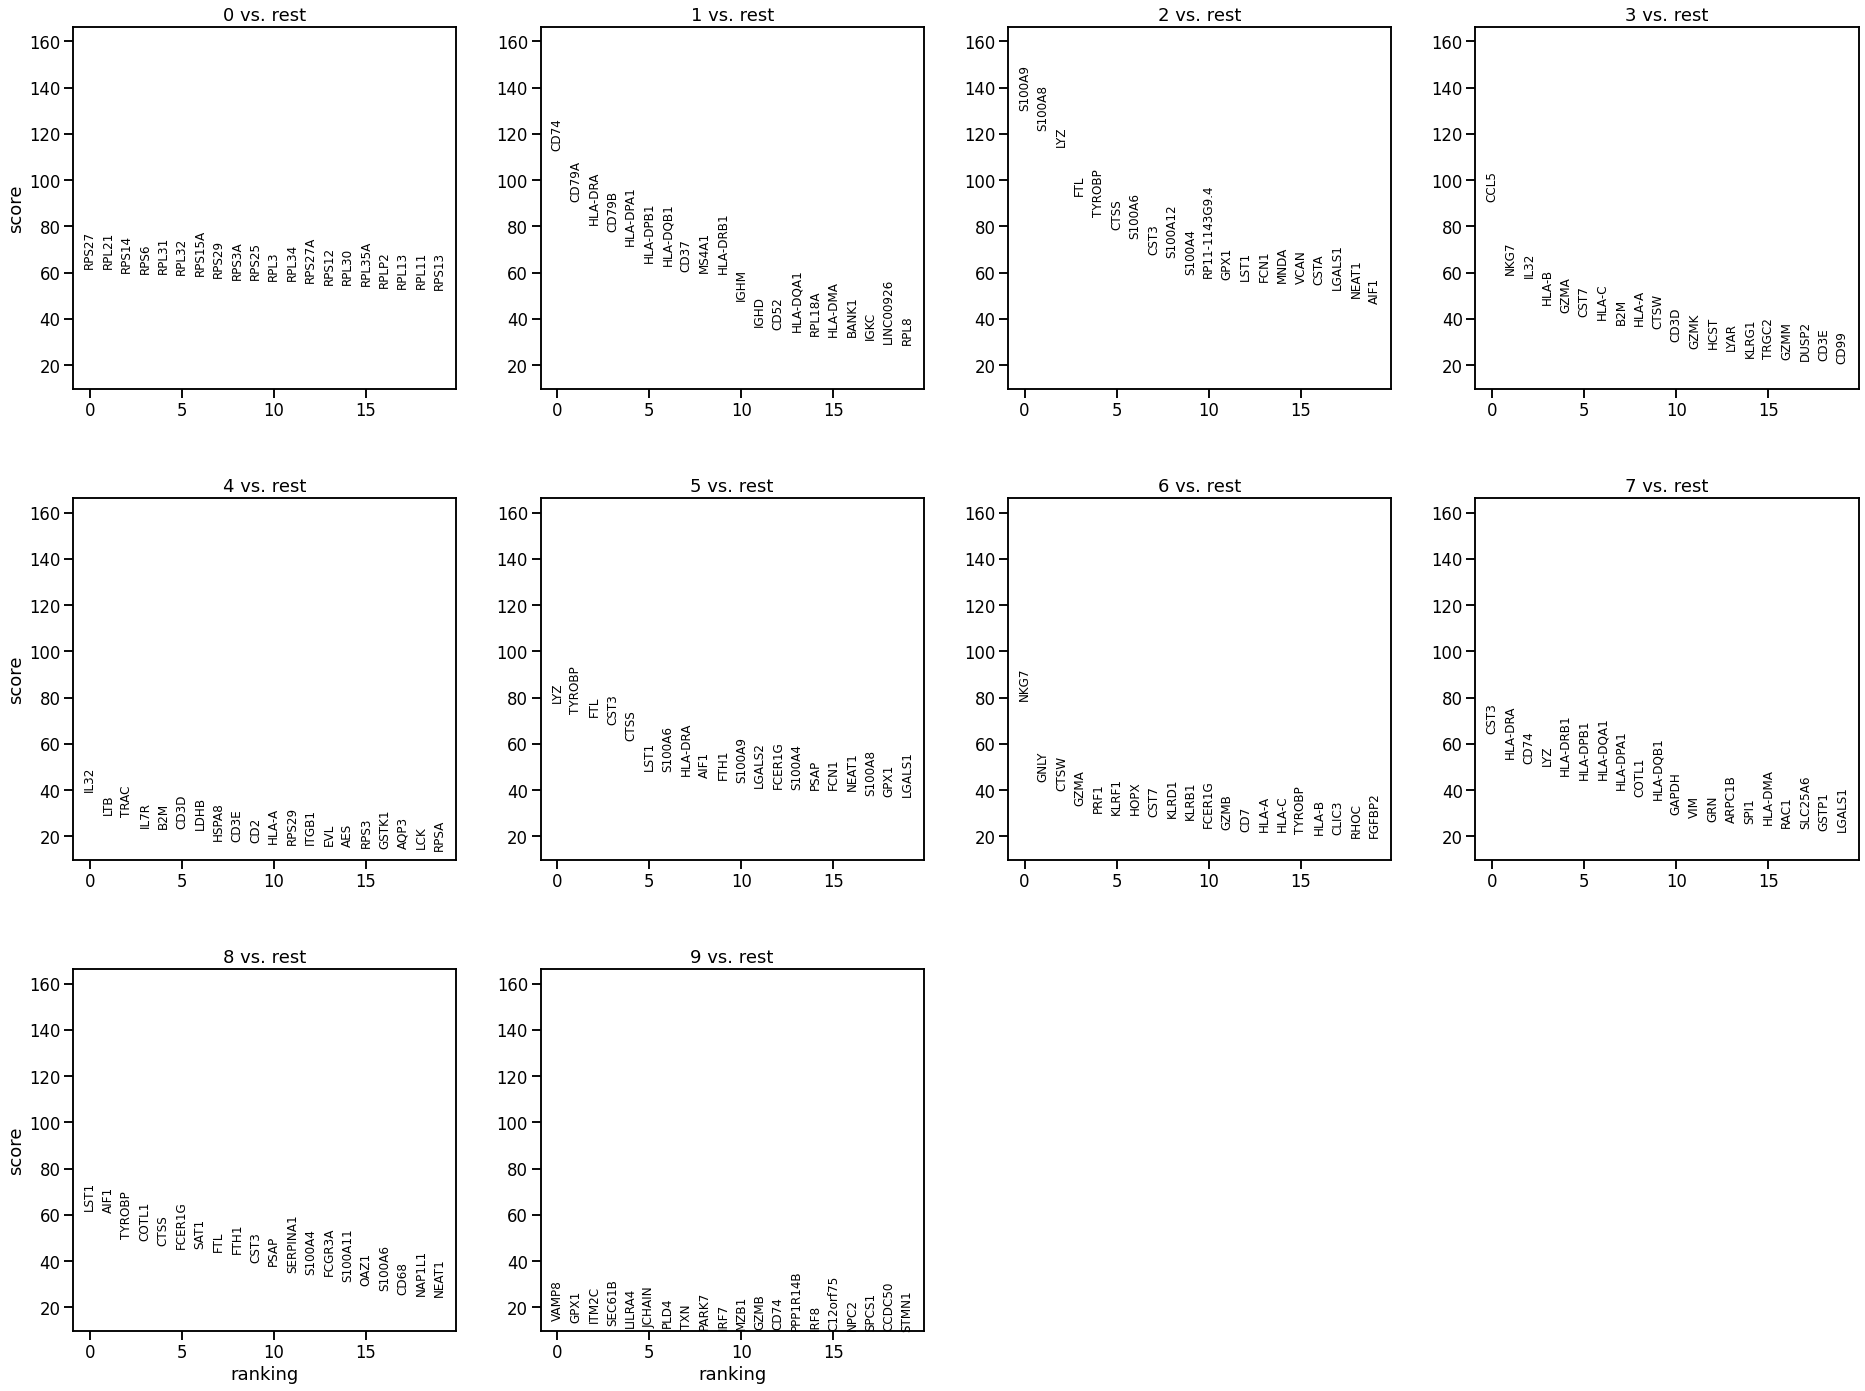

In [22]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', fontsize=12)

Instead of the rank plot with gene names per cluster, we can also use the `dotplot/matrixplot/stacked violin` plot function to visualise the characteristic genes per cluster. Please note that the function name starts with `rank_genes_groups_`, when you want to plot the gene ranks in a `dotplot/matrixplot/stacked violin` plot. 

    using 'X_pca' with n_pcs = 6
Storing dendrogram info using `.uns["dendrogram_['leiden_r0.5']"]`


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


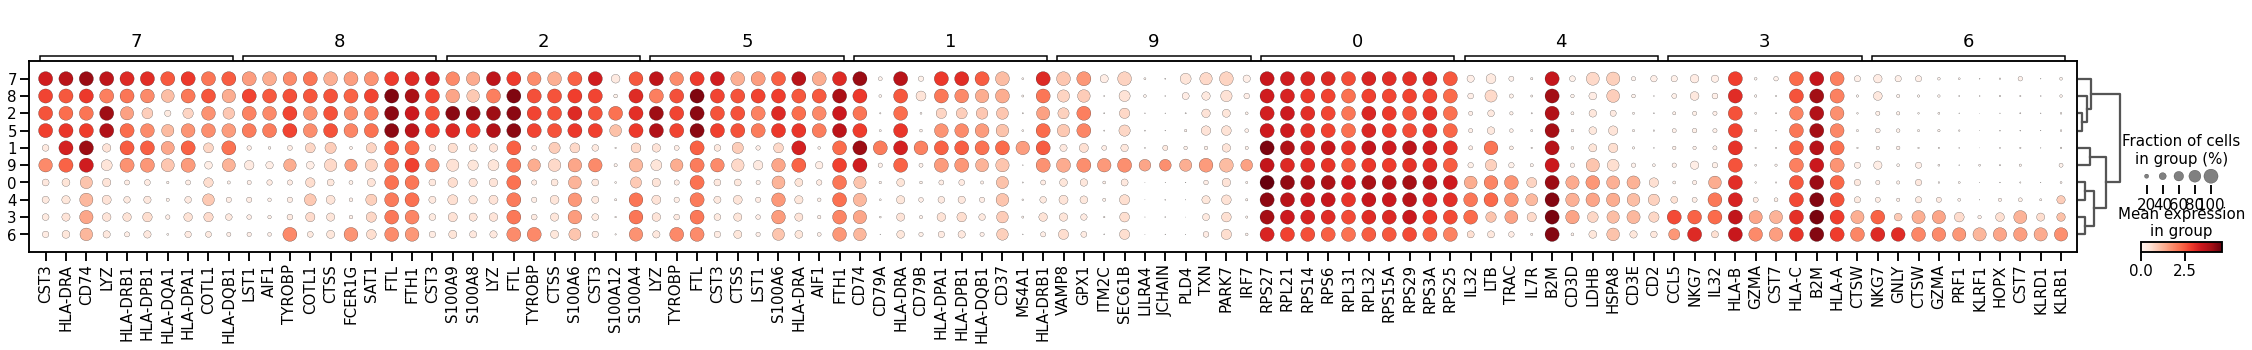

In [27]:
sc.pl.rank_genes_groups_dotplot(adata, key ='rank_genes_r0.5')

In [23]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden_r1.5', key_added='rank_genes_r1.5')

ranking genes
    finished: added to `.uns['rank_genes_r1.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


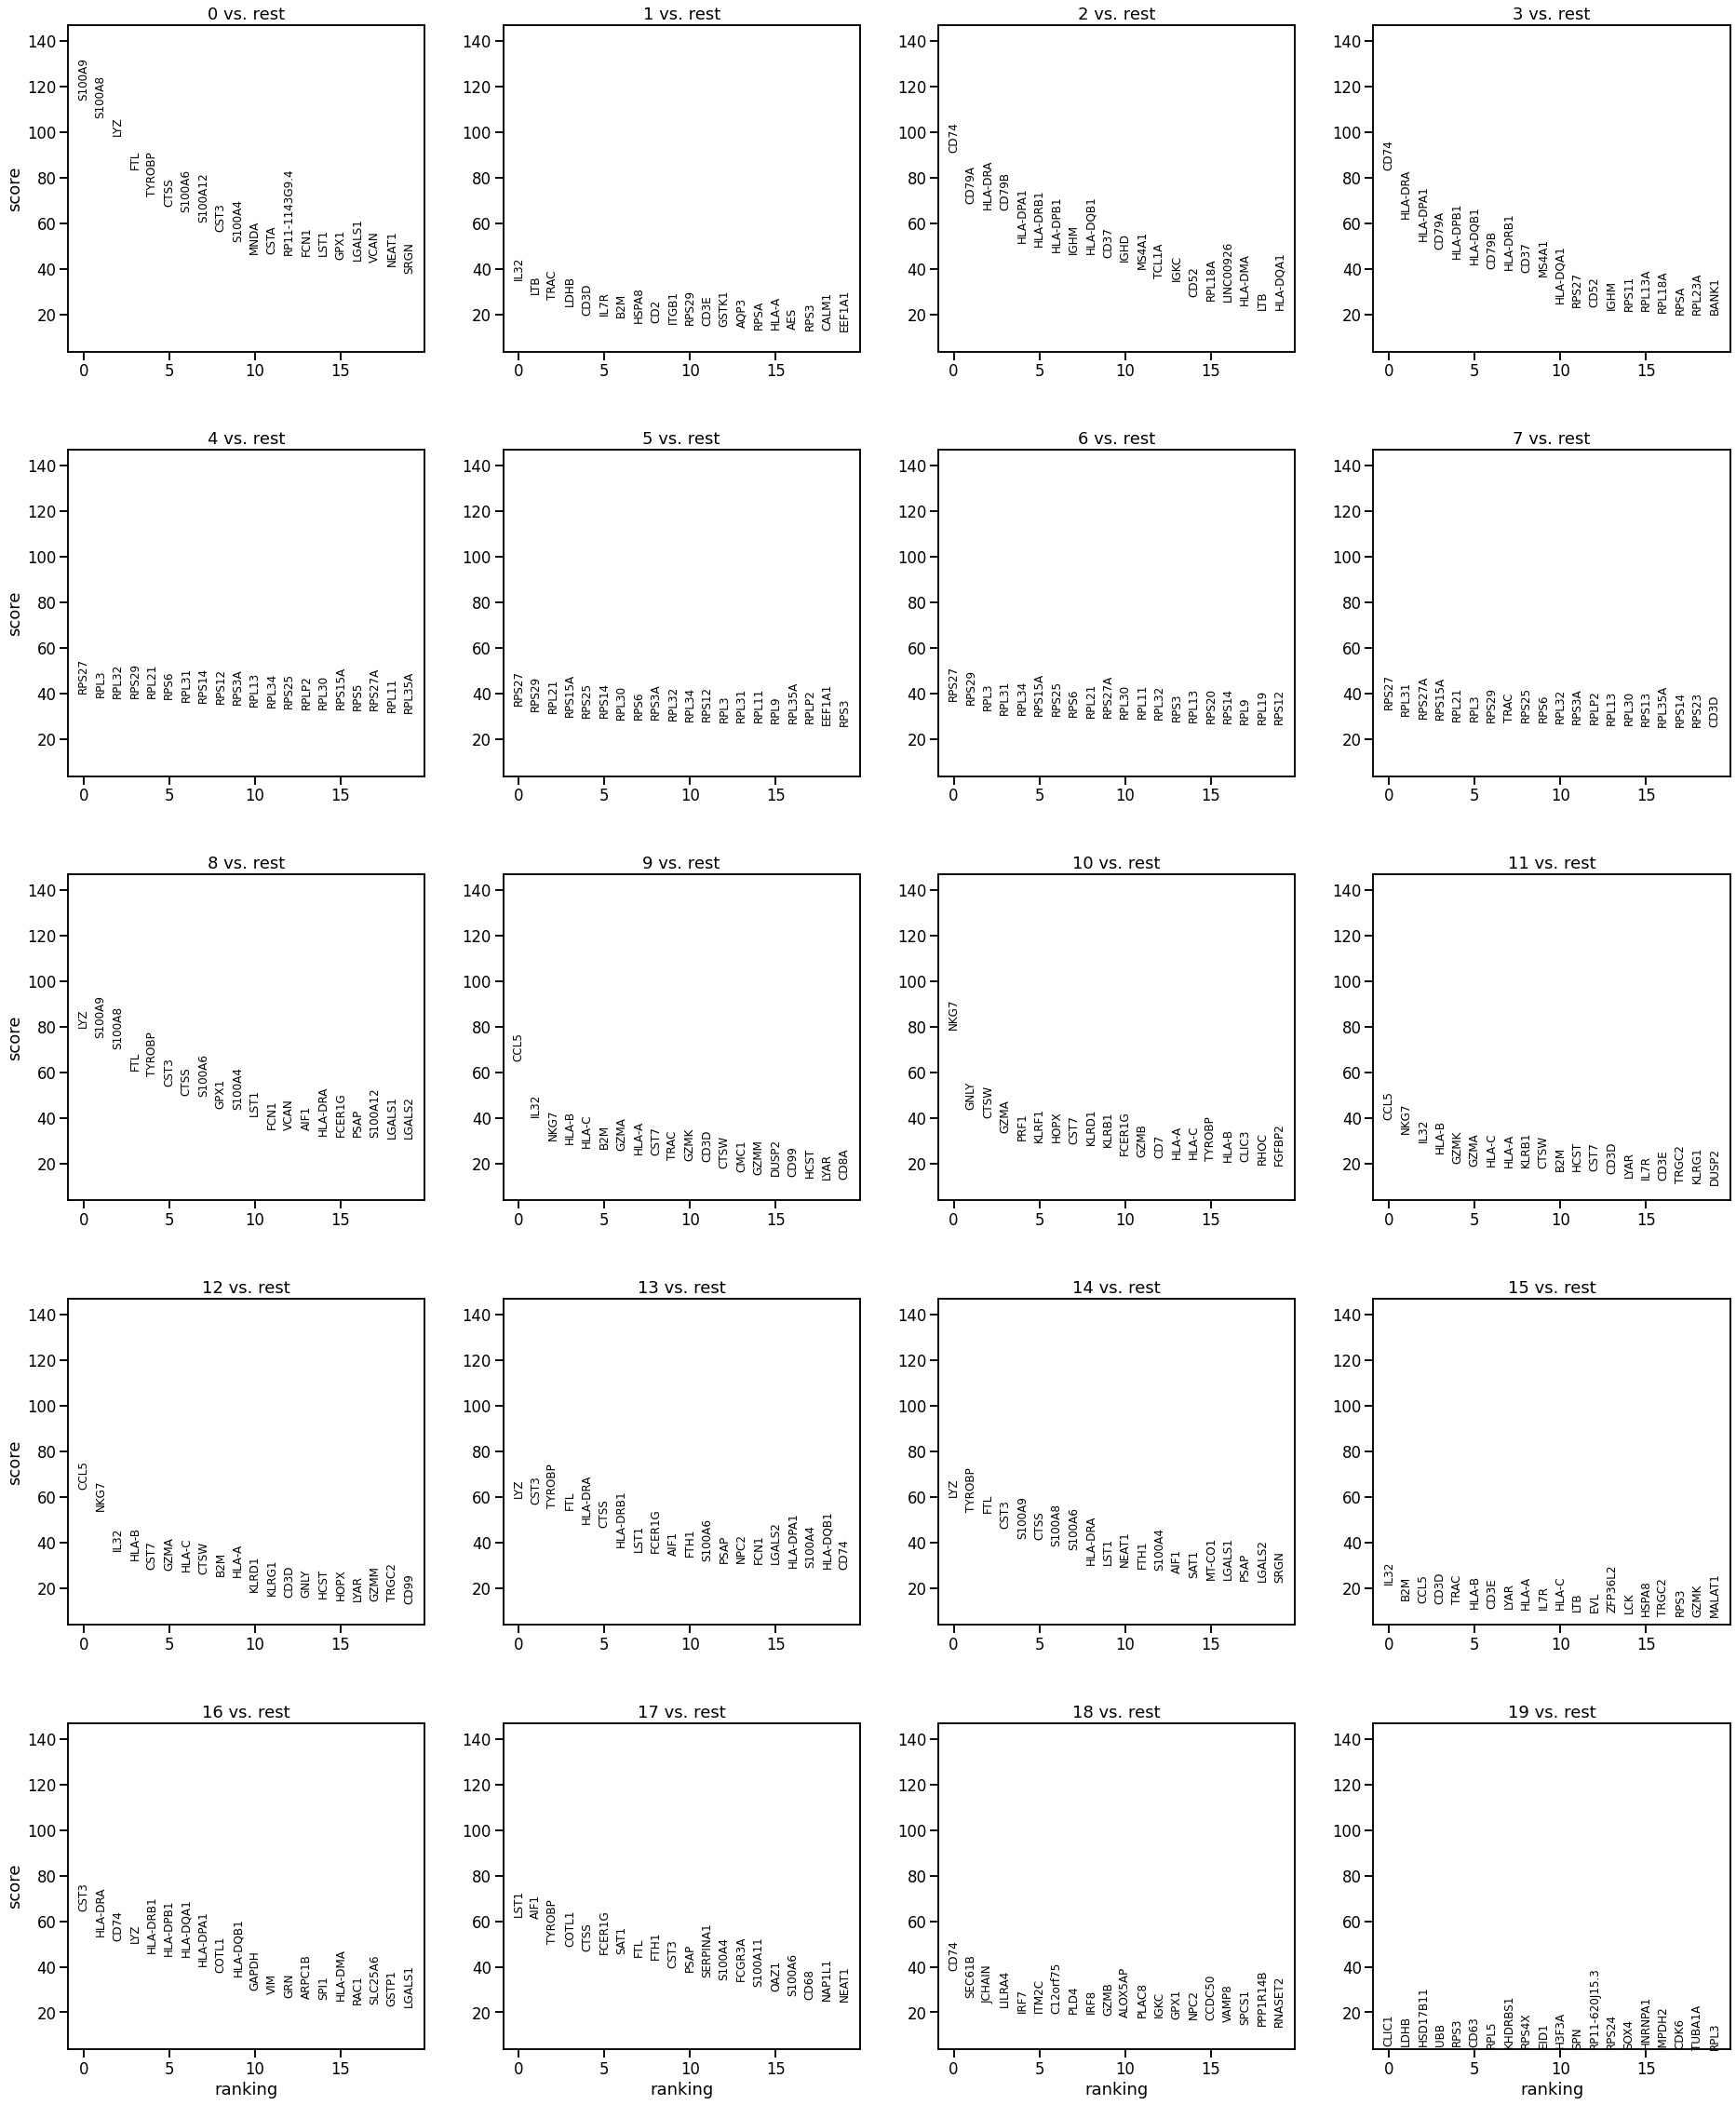

In [24]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r1.5', fontsize=12)

Here, we observe a considerable ribosomal proteins (*RPL* and *RPS*), which are part of the ribosomes. Thus, they are involved in mRNA translational processes. Usually, these genes are difficult to interpret.

When it comes to cluster annotation, we have to tap into prior knowledge of the cell type. Depending on the data set, this may involve extensive literature search. In the case of PBMCs, we may refer to several studies and single-cell RNA-sequencing data analysis tutorials to extract marker gene sets. 

The following list is extracted from the Seurat tutorial on PBMCs.


|Marker Gene|Cell Type|
|---------|-------|
|IL7R|CD4 T cells|
|CD14, LYZ|CD14+ Monocytes|
|MS4A1|B cells|
|CD8A|CD8 T cells|
|FCGR3A, MS4A7|FCGR3A+ Monocytes|
|GNLY, NKG7|NK cells|
|FCER1A, CST3|Dendritic Cells|
|PPBP|Megakaryocytes|


Let us define a list of marker genes from literature.

In [41]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1','CD3D', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Further, we can use a dictionary to define markers for specific cell types. `Scanpy` then displays a bracket with the cell type name e.g. in the `dotplot`.

In [35]:
marker_genes_dict = {
    'T cells': ['CD3D'],
    'CD4 T cells': ['IL7R'],
    'CD8 T cells': ['CD8A'],
    'NK cells': ['GNLY', 'NKG7'],
    'Dendritic cells': ['FCGR1A', 'CST3'],
    'B cells': ['MS4A1'],
    'CD14+ monocytes': ['CD14', 'LYZ'],
    'FCGR3A+ monocytes': ['FCGR3A', 'MS4A7'],
    'Megakaryocytes': ['PPBP']
}

Annotate the clusters. You can use auxilliary plots like `matrixplot`, `dotplot`,`heatmap` or `violin` plots or coloring an embedding by the marker genes.

Let us check if the marker genes are expressed in our dataset.

In [36]:
np.in1d(marker_genes, adata.var_names)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

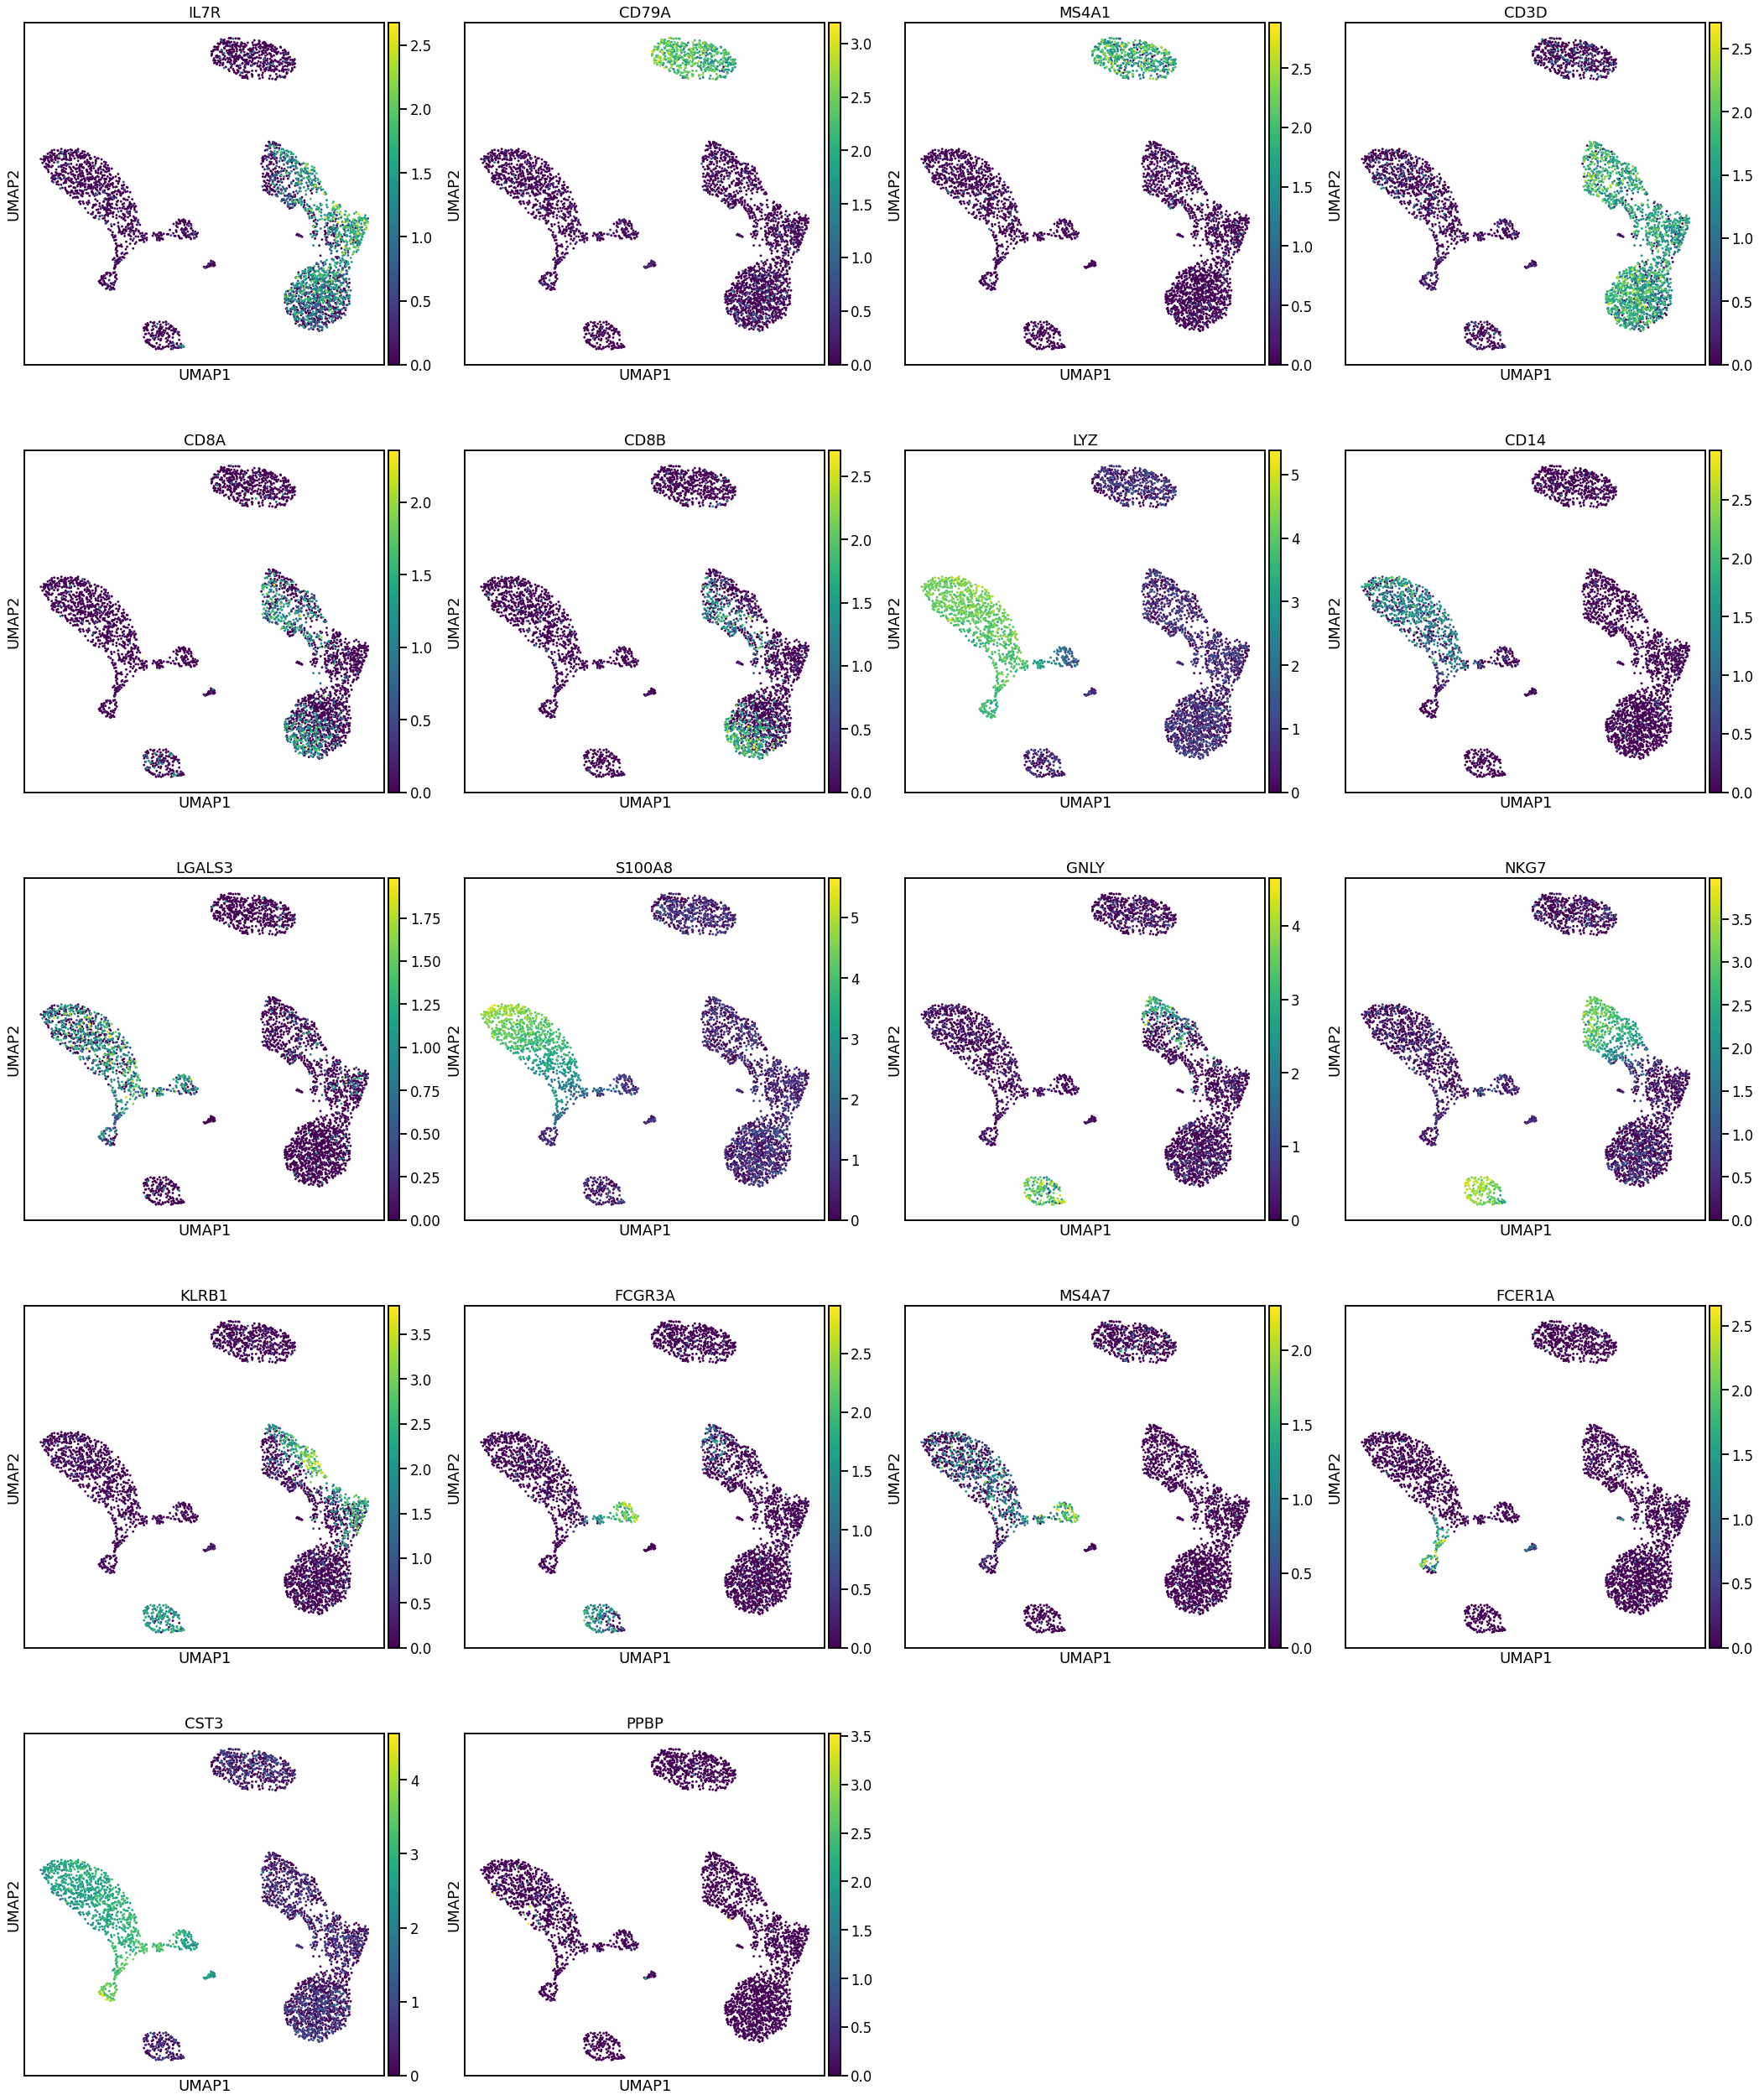

In [42]:
sc.pl.umap(adata=adata, color=marker_genes, use_raw=False)

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


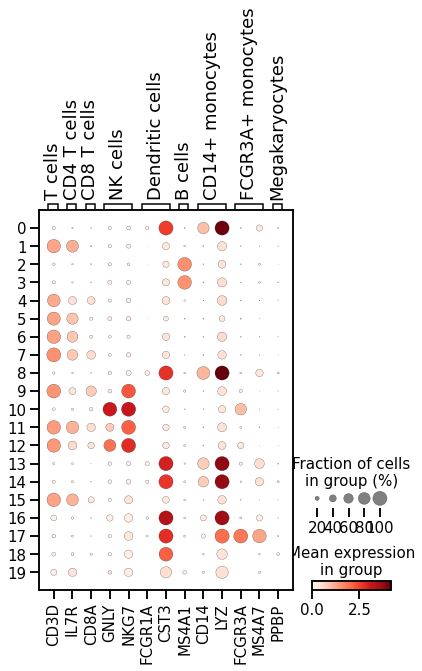

In [38]:
sc.pl.dotplot(adata, marker_genes_dict, groupby='leiden_r1.5', use_raw=False)

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


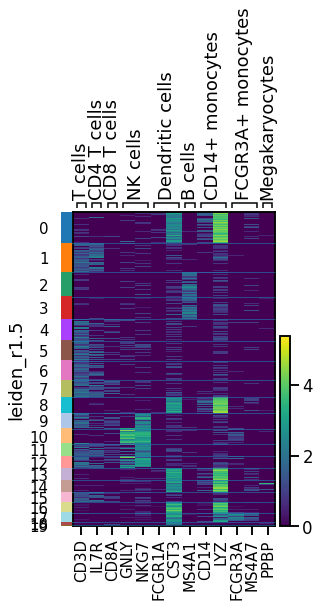

In [39]:
sc.pl.heatmap(adata=adata, var_names=marker_genes_dict,
              groupby='leiden_r1.5', use_raw=False, vmin=0)

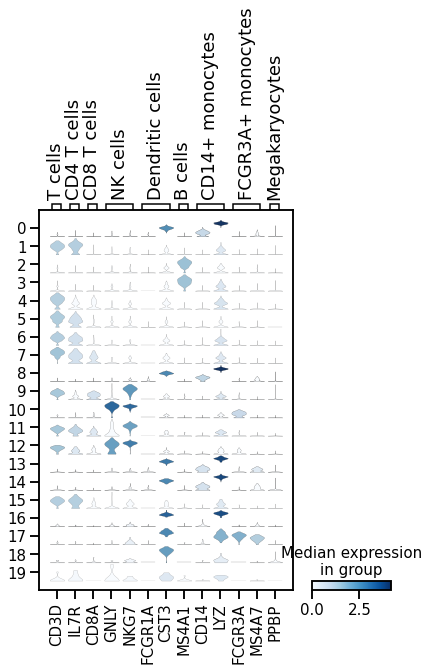

In [40]:
sc.pl.stacked_violin(adata, marker_genes_dict, groupby='leiden_r1.5', use_raw=False)

Use the `pandas` data frame functionality to rename your clusters and visualize your annotation. Here, we use a dictionary to annotate the clusters.

In [43]:
cluster2annotation = {
    '0': 'CD14+ monocytes',
    '1': 'CD4 T cells',
    '2': 'B cells',
    '3': 'B cells',
    '4': 'CD8 T cells',
    '5': 'CD4 T cells',
    '6': 'CD4 T cells',
    '7': 'CD8 T cells',
    '8': 'CD14+ monocytes',
    '9': 'NK cells',
    '10': 'NK cells',
    '11': 'NK cells',
    '12': 'NK cells',
    '13': 'CD14+ monocytes',
    '14': 'CD14+ monocytes',
    '15': 'CD4 T cells',
    '16': 'Dendritic Cells',
    '17': 'FCGR3A+ monocytes',
    '18': 'Dendritic Cells',
    '19': 'CD4 T cells',
}

In [46]:
adata.obs['annotated'] = adata.obs['leiden_r1.5'].map(cluster2annotation).astype('category')

In [47]:
adata.obs['annotated'].value_counts()

CD4 T cells          921
CD14+ monocytes      819
NK cells             636
B cells              539
CD8 T cells          440
Dendritic Cells      150
FCGR3A+ monocytes    113
Name: annotated, dtype: int64

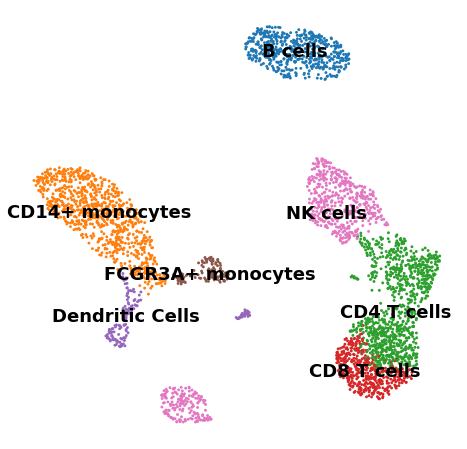

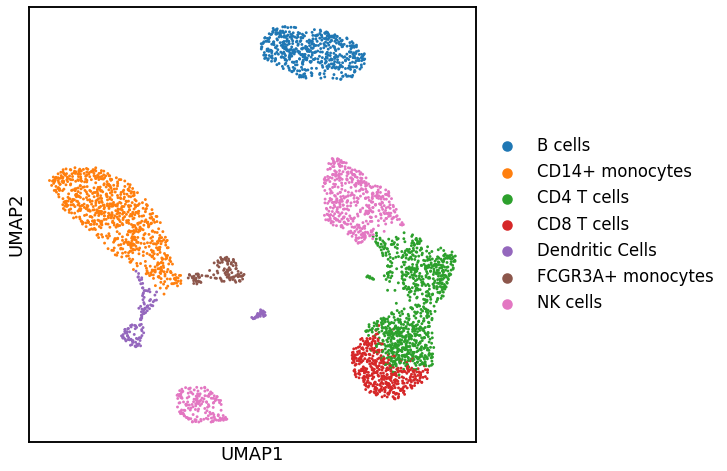

In [48]:
sc.pl.umap(adata, color='annotated', legend_loc='on data', title='', frameon=False)
sc.pl.umap(adata, color='annotated',  title='', frameon=True)

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


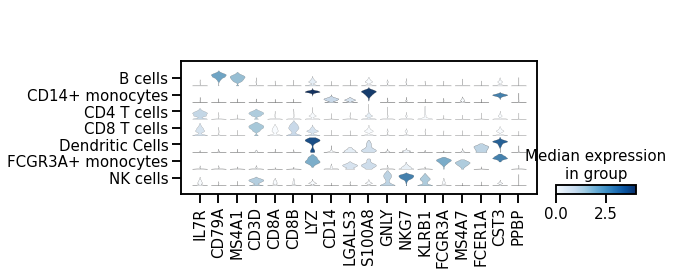

In [49]:
sc.pl.stacked_violin(adata, marker_genes, groupby='annotated', use_raw=False)

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/python/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


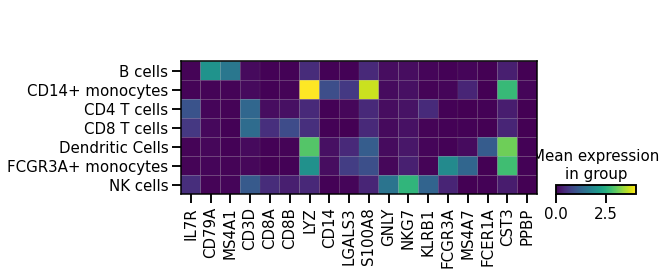

In [50]:
sc.pl.matrixplot(adata, marker_genes, groupby='annotated', use_raw=False, vmin=0)

### Inspect subpopulations of B cells

Let us determine the differences in the B cell clusters by differential expression. Subcluster the B cells first.

In [51]:
sc.tl.leiden(adata, resolution=0.2, restrict_to = ['annotated',['B cells']], key_added='leiden_R')

running Leiden clustering
    finished: found 8 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:00:00)


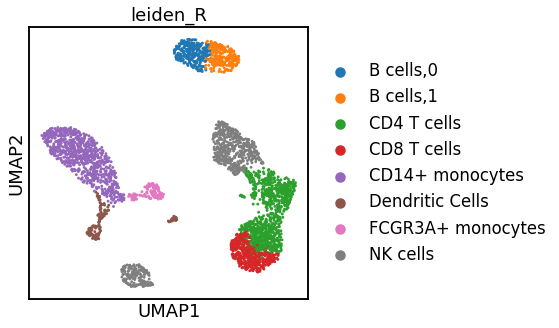

In [52]:
rcParams['figure.figsize']= (5,5)
sc.pl.umap(adata, color='leiden_R')

In [53]:
sc.tl.rank_genes_groups(adata = adata, groupby='leiden_R', groups= ['B cells,1'],
                        reference='B cells,0', rankby_abs=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


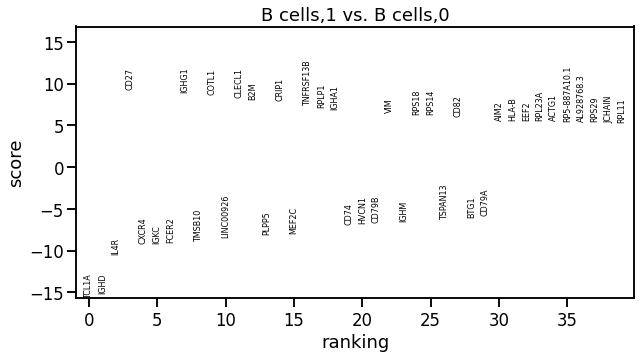

In [54]:
rcParams['figure.figsize']=(10,5)
sc.pl.rank_genes_groups(adata, size=10, n_genes=40)

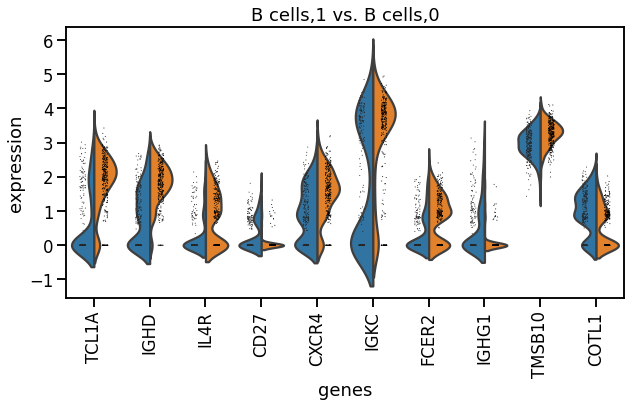

In [55]:
sc.pl.rank_genes_groups_violin(adata, groups='B cells,1', n_genes=10, use_raw=False)

Here, the B cell populations differ in B cell activation markers such as TCL1A and IL4R. Interestingly, the `B cells,0` population is almost exclusively positive for the *IGKC* gene. The *IGKC* gene was found to be predictive for cancer prognosis.
Potentially, `B cells,0` are activated B cells and `B cells,1` are resting, but we have to look at more markers to make the distinction. 

Similarly, we could characterise the subtypes of NK cells, which may contain both NKT cells and NK cells.

## Save annotated data to file

At this point, we have finished the data annotation. This represents another milestone in the data analysis of single cell data. Once the annotation is finished, we won't have to touch this part of the analysis again.   

In [56]:
adata.write(data_dir + 'data_annotated.h5ad')

**Comment:** End of fifth session. In the next session, we will use the annotated data in the cellxgene browser. Please close and shutdown your jupyter session for this.